<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Modelo de lenguaje con tokenización por caracteres

### Consigna
- Seleccionar un corpus de texto sobre el cual entrenar el modelo de lenguaje.
- Realizar el pre-procesamiento adecuado para tokenizar el corpus, estructurar el dataset y separar entre datos de entrenamiento y validación.
- Proponer arquitecturas de redes neuronales basadas en unidades recurrentes para implementar un modelo de lenguaje.
- Con el o los modelos que consideren adecuados, generar nuevas secuencias a partir de secuencias de contexto con las estrategias de greedy search y beam search determístico y estocástico. En este último caso observar el efecto de la temperatura en la generación de secuencias.


### Sugerencias
- Durante el entrenamiento, guiarse por el descenso de la perplejidad en los datos de validación para finalizar el entrenamiento. Para ello se provee un callback.
- Explorar utilizar SimpleRNN (celda de Elman), LSTM y GRU.
- rmsprop es el optimizador recomendado para la buena convergencia. No obstante se pueden explorar otros.


In [1]:
import random
import io
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras import layers
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Dropout
from tensorflow.keras.losses import SparseCategoricalCrossentropy

### Datos
Utilizaremos como dataset canciones de bandas de habla inglés.

In [3]:
# descargar de textos.info
import urllib.request

# Para leer y parsear el texto en HTML de wikipedia
import bs4 as bs

In [4]:
# Abrir y leer el contenido del archivo 'martin_fierro.txt'
with open('martin_fierro.txt', 'r', encoding='utf-8') as file:
    texto = file.read()

# Mostrar los primeros 500 caracteres para verificar que se cargó bien
print(texto[:500])

El Gaucho Martín Fierro
José Hernández

1

Texto núm. 4187
Título: El Gaucho Martín Fierro
Autor: José Hernández
Etiquetas: Poesía
Editor: Edu Robsy
Fecha de creación: 13 de enero de 2019
Fecha de modificación: 13 de enero de 2019
Edita textos.info
Maison Carrée
c/ Ramal, 48
07730 Alayor - Menorca
Islas Baleares
España



2

I
Aquí me pongo a cantar
al compás de la vigüela,
que el hombre que lo desvela
una pena estrordinaria,
como la ave solitaria
con el cantar se consuela.
Pido a los Santos d


In [5]:
# en article text se encuentra el texto de todo el libro
texto[:10000]

'El Gaucho Martín Fierro\nJosé Hernández\n\n1\n\n\x0cTexto núm. 4187\nTítulo: El Gaucho Martín Fierro\nAutor: José Hernández\nEtiquetas: Poesía\nEditor: Edu Robsy\nFecha de creación: 13 de enero de 2019\nFecha de modificación: 13 de enero de 2019\nEdita textos.info\nMaison Carrée\nc/ Ramal, 48\n07730 Alayor - Menorca\nIslas Baleares\nEspaña\n\n\n\n2\n\n\x0cI\nAquí me pongo a cantar\nal compás de la vigüela,\nque el hombre que lo desvela\nuna pena estrordinaria,\ncomo la ave solitaria\ncon el cantar se consuela.\nPido a los Santos del Cielo\nque ayuden mi pensamiento,\nles pido en este momento\nque voy a cantar mi historia\nme refresquen la memoria\ny aclaren mi entendimiento.\nVengan Santos milagrosos,\nvengan todos en mi ayuda,\nque la lengua se me añuda\ny se me turba la vista;\npido a mi Dios que me asista\nen una ocasión tan ruda.\nYo he visto muchos cantores,\ncon famas bien otenidas,\ny que después de alquiridas\nno las quieren sustentarparece que sin largar\nse cansaron en parti

### Elegir el tamaño del contexto

En este caso, como el modelo de lenguaje es por caracteres, todo un gran corpus
de texto puede ser considerado un documento en sí mismo y el tamaño de contexto
puede ser elegido con más libertad en comparación a un modelo de lenguaje tokenizado por palabras y dividido en documentos más acotados.

In [7]:
# seleccionamos el tamaño de contexto
max_context_size = 100

In [8]:
# Usaremos las utilidades de procesamiento de textos y secuencias de Keras
from tensorflow.keras.utils import pad_sequences # se utilizará para padding

In [9]:
# en este caso el vocabulario es el conjunto único de caracteres que existe en todo el texto
chars_vocab = set(texto)

In [10]:
# la longitud de vocabulario de caracteres es:
len(chars_vocab)

80

In [11]:
# Construimos los dicionarios que asignan índices a caracteres y viceversa.
# El diccionario `char2idx` servirá como tokenizador.
char2idx = {k: v for v,k in enumerate(chars_vocab)}
idx2char = {v: k for k,v in char2idx.items()}

###  Tokenizar

In [13]:
# tokenizamos el texto completo
tokenized_text = [char2idx[ch] for ch in texto]

In [14]:
tokenized_text[:1000]

[52,
 0,
 73,
 35,
 53,
 61,
 63,
 31,
 22,
 73,
 75,
 53,
 5,
 51,
 66,
 36,
 73,
 15,
 19,
 37,
 5,
 5,
 22,
 1,
 20,
 22,
 46,
 72,
 73,
 16,
 37,
 5,
 36,
 3,
 36,
 42,
 37,
 28,
 1,
 1,
 11,
 1,
 1,
 54,
 8,
 37,
 6,
 51,
 22,
 73,
 36,
 64,
 58,
 32,
 73,
 18,
 11,
 38,
 4,
 1,
 8,
 66,
 51,
 61,
 0,
 22,
 29,
 73,
 52,
 0,
 73,
 35,
 53,
 61,
 63,
 31,
 22,
 73,
 75,
 53,
 5,
 51,
 66,
 36,
 73,
 15,
 19,
 37,
 5,
 5,
 22,
 1,
 10,
 61,
 51,
 22,
 5,
 29,
 73,
 20,
 22,
 46,
 72,
 73,
 16,
 37,
 5,
 36,
 3,
 36,
 42,
 37,
 28,
 1,
 52,
 51,
 19,
 14,
 61,
 37,
 51,
 53,
 46,
 29,
 73,
 50,
 22,
 37,
 46,
 66,
 53,
 1,
 52,
 42,
 19,
 51,
 22,
 5,
 29,
 73,
 52,
 42,
 61,
 73,
 25,
 22,
 30,
 46,
 69,
 1,
 15,
 37,
 63,
 31,
 53,
 73,
 42,
 37,
 73,
 63,
 5,
 37,
 53,
 63,
 19,
 9,
 36,
 29,
 73,
 11,
 40,
 73,
 42,
 37,
 73,
 37,
 36,
 37,
 5,
 22,
 73,
 42,
 37,
 73,
 47,
 57,
 11,
 44,
 1,
 15,
 37,
 63,
 31,
 53,
 73,
 42,
 37,
 73,
 58,
 22,
 42,
 19,
 26,
 19,
 63,
 53,
 63

### Organizando y estructurando el dataset

In [27]:
# separaremos el dataset entre entrenamiento y validación.
# `p_val` será la proporción del corpus que se reservará para validación
# `num_val` es la cantidad de secuencias de tamaño `max_context_size` que se usará en validación
p_val = 0.1
num_val = int(np.ceil(len(tokenized_text)*p_val/max_context_size))

In [29]:
# separamos la porción de texto utilizada en entrenamiento de la de validación.
train_text = tokenized_text[:-num_val*max_context_size]
val_text = tokenized_text[-num_val*max_context_size:]

In [31]:
tokenized_sentences_val = [val_text[init*max_context_size:init*(max_context_size+1)] for init in range(num_val)]

In [33]:
tokenized_sentences_train = [train_text[init:init+max_context_size] for init in range(len(train_text)-max_context_size+1)]

In [35]:
X = np.array(tokenized_sentences_train[:-1])
y = np.array(tokenized_sentences_train[1:])

Nótese que estamos estructurando el problema de aprendizaje como *many-to-many*:

Entrada: secuencia de tokens [$x_0$, $x_1$, ..., $x_N$]

Target: secuencia de tokens [$x_1$, $x_2$, ..., $x_{N+1}$]

De manera que la red tiene que aprender que su salida deben ser los tokens desplazados en una posición y un nuevo token predicho (el N+1).

La ventaja de estructurar el aprendizaje de esta manera es que para cada token de target se propaga una señal de gradiente por el grafo de cómputo recurrente, que es mejor que estructurar el problema como *many-to-one* en donde sólo una señal de gradiente se propaga.

En este punto tenemos en la variable `tokenized_sentences` los versos tokenizados. Vamos a quedarnos con un conjunto de validación que utilizaremos para medir la calidad de la generación de secuencias con la métrica de Perplejidad.

In [39]:
X.shape

(54603, 100)

In [41]:
X[0,:10]

array([52,  0, 73, 35, 53, 61, 63, 31, 22, 73])

In [43]:
y[0,:10]

array([ 0, 73, 35, 53, 61, 63, 31, 22, 73, 75])

In [45]:
vocab_size = len(chars_vocab)
vocab_size

80

# Definiendo el modelo SimpleRNN

In [48]:
from keras.layers import Input, TimeDistributed, CategoryEncoding, SimpleRNN, Dense
from keras.models import Model, Sequential

El modelo que se propone como ejemplo consume los índices de los tokens y los transforma en vectores OHE (en este caso no entrenamos una capa de embedding para caracteres). Esa transformación se logra combinando las capas `CategoryEncoding` que transforma a índices a vectores OHE y `TimeDistributed` que aplica la capa a lo largo de la dimensión "temporal" de la secuencia.

In [51]:
model = Sequential()

model.add(TimeDistributed(CategoryEncoding(num_tokens=vocab_size, output_mode = "one_hot"),input_shape=(None,1)))
model.add(SimpleRNN(200, return_sequences=True, dropout=0.1, recurrent_dropout=0.1 ))
model.add(Dense(vocab_size, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop')

model.summary()

C:\Users\Chelo\anaconda3\Lib\site-packages\keras\src\layers\core\wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ (None, None, 80)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ (None, None, 200)      │        56,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, None, 80)       │        16,080 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 72,280 (282.34 KB)

 Trainable params: 72,280 (282.34 KB)

 Non-trainable params: 0 (0.00 B)


### Definir el modelo

Dado que por el momento no hay implementaciones adecuadas de la perplejidad que puedan operar en tiempo de entrenamiento, armaremos un Callback *ad-hoc* que la calcule en cada epoch.

**Nota**: un Callback es una rutina gatillada por algún evento, son muy útiles para relevar datos en diferentes momentos del desarrollo del modelo. En este caso queremos hacer un cálculo cada vez que termina una epoch de entrenamiento.

In [55]:
class PplCallback(keras.callbacks.Callback):

    '''
    Este callback es una solución ad-hoc para calcular al final de cada epoch de
    entrenamiento la métrica de Perplejidad sobre un conjunto de datos de validación.
    La perplejidad es una métrica cuantitativa para evaluar la calidad de la generación de secuencias.
    Además implementa la finalización del entrenamiento (Early Stopping)
    si la perplejidad no mejora después de `patience` epochs.
    '''

    def __init__(self, val_data, history_ppl,patience=5):
      # El callback lo inicializamos con secuencias de validación sobre las cuales
      # mediremos la perplejidad
      self.val_data = val_data

      self.target = []
      self.padded = []

      count = 0
      self.info = []
      self.min_score = np.inf
      self.patience_counter = 0
      self.patience = patience

      # nos movemos en todas las secuencias de los datos de validación
      for seq in self.val_data:

        len_seq = len(seq)
        # armamos todas las subsecuencias
        subseq = [seq[:i] for i in range(1,len_seq)]
        self.target.extend([seq[i] for i in range(1,len_seq)])

        if len(subseq)!=0:

          self.padded.append(pad_sequences(subseq, maxlen=max_context_size, padding='pre'))

          self.info.append((count,count+len_seq))
          count += len_seq

      self.padded = np.vstack(self.padded)


    def on_epoch_end(self, epoch, logs=None):

        # en `scores` iremos guardando la perplejidad de cada secuencia
        scores = []

        predictions = self.model.predict(self.padded,verbose=0)

        # para cada secuencia de validación
        for start,end in self.info:

          # en `probs` iremos guardando las probabilidades de los términos target
          probs = [predictions[idx_seq,-1,idx_vocab] for idx_seq, idx_vocab in zip(range(start,end),self.target[start:end])]

          # calculamos la perplejidad por medio de logaritmos
          scores.append(np.exp(-np.sum(np.log(probs))/(end-start)))

        # promediamos todos los scores e imprimimos el valor promedio
        current_score = np.mean(scores)
        history_ppl.append(current_score)
        print(f'\n mean perplexity: {current_score} \n')

        # chequeamos si tenemos que detener el entrenamiento
        if current_score < self.min_score:
          self.min_score = current_score
          self.model.save("my_model.keras")
          print("Saved new model!")
          self.patience_counter = 0
        else:
          self.patience_counter += 1
          if self.patience_counter == self.patience:
            print("Stopping training...")
            self.model.stop_training = True


### Entrenamiento

In [58]:
# fiteamos, nótese el agregado del callback con su inicialización. El batch_size lo podemos seleccionar a mano
# en general, lo mejor es escoger el batch más grande posible que minimice el tiempo de cada época.
# En la variable `history_ppl` se guardarán los valores de perplejidad para cada época.
history_ppl = []
hist = model.fit(X, y, epochs=20, callbacks=[PplCallback(tokenized_sentences_val,history_ppl)], batch_size=256)

Epoch 1/20
213/214 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 3.0229
 mean perplexity: 10.09808671061982 

Saved new model!
214/214 ━━━━━━━━━━━━━━━━━━━━ 31s 117ms/step - loss: 3.0200
Epoch 2/20
213/214 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - loss: 2.2931
 mean perplexity: 9.569748756413999 

Saved new model!
214/214 ━━━━━━━━━━━━━━━━━━━━ 21s 98ms/step - loss: 2.2927
Epoch 3/20
213/214 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - loss: 2.1701
 mean perplexity: 9.550679786616875 

Saved new model!
214/214 ━━━━━━━━━━━━━━━━━━━━ 20s 95ms/step - loss: 2.1699
Epoch 4/20
213/214 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - loss: 2.1005
 mean perplexity: 9.584416771421365 

214/214 ━━━━━━━━━━━━━━━━━━━━ 20s 95ms/step - loss: 2.1004
Epoch 5/20
213/214 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - loss: 2.0414
 mean perplexity: 9.669680027325011 

214/214 ━━━━━━━━━━━━━━━━━━━━ 21s 98ms/step - loss: 2.0413
Epoch 6/20
213/214 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - loss: 1.9898
 mean perplexity: 9.165449870367937 

Saved new model!
214/2

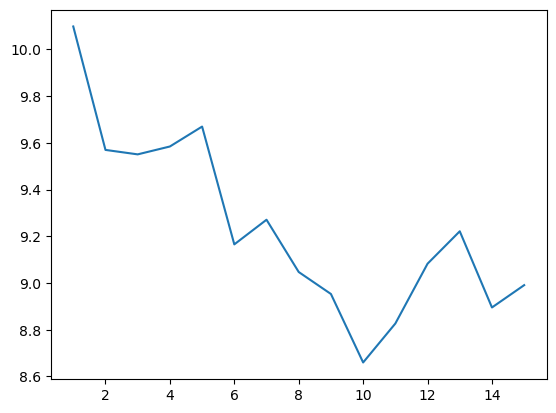

In [60]:
import matplotlib.pyplot as plt
import seaborn as sns

# Entrenamiento
epoch_count = range(1, len(history_ppl) + 1)
sns.lineplot(x=epoch_count,  y=history_ppl)
plt.show()

In [62]:
# Cargamos el mejor modelo guardado del entrenamiento para hacer inferencia
model = keras.models.load_model('my_model.keras')


### Predicción del próximo caracter

In [64]:
# Se puede usar gradio para probar el modelo
# Gradio es una herramienta muy útil para crear interfaces para ensayar modelos
# https://gradio.app/

!pip install -q gradio

In [66]:
import gradio as gr

def model_response(human_text):

    # Encodeamos
    encoded = [char2idx[ch] for ch in human_text.lower() ]
    # Si tienen distinto largo
    encoded = pad_sequences([encoded], maxlen=max_context_size, padding='pre')

    # Predicción softmax
    y_hat = np.argmax(model.predict(encoded)[0,-1,:])


    # Debemos buscar en el vocabulario el caracter
    # que corresopnde al indice (y_hat) predicho por le modelo
    out_word = ''
    out_word = idx2char[y_hat]

    # Agrego la palabra a la frase predicha
    return human_text + out_word

iface = gr.Interface(
    fn=model_response,
    inputs=["textbox"],
    outputs="text")

iface.launch(debug=True)

* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Keyboard interruption in main thread... closing server.


### Generación de secuencias

In [70]:
def generate_seq(model, seed_text, max_length, n_words):
    """
        Exec model sequence prediction

        Args:
            model (keras): melo entrenado
            seed_text (string): texto de entrada (input_seq)
            max_length (int): máxima longitud de la sequencia de entrada
            n_words (int): números de caracteres a agregar a la sequencia de entrada
        returns:
            output_text (string): sentencia con las "n_words" agregadas
    """
    output_text = seed_textod
	# generate a fixed number of words
    for _ in range(n_words):
		# Encodeamos
        encoded = [char2idx[ch] for ch in output_text.lower() ]
		# Si tienen distinto largo
        encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

		# Predicción softmax
        y_hat = np.argmax(model.predict(encoded,verbose=0)[0,-1,:])
		# Vamos concatenando las predicciones
        out_word = ''

        out_word = idx2char[y_hat]

		# Agrego las palabras a la frase predicha
        output_text += out_word
    return output_text

In [74]:
input_text='la cosa anda tan fruncida'

generate_seq(model, input_text, max_length=max_context_size, n_words=30)

'la cosa anda tan fruncida\ny al palo en el carreron\nlos '

###  Beam search y muestreo aleatorio

In [76]:
# funcionalidades para hacer encoding y decoding

def encode(text,max_length=max_context_size):

    encoded = [char2idx[ch] for ch in text]
    encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

    return encoded

def decode(seq):
    return ''.join([idx2char[ch] for ch in seq])

In [78]:
from scipy.special import softmax

# función que selecciona candidatos para el beam search
def select_candidates(pred,num_beams,vocab_size,history_probs,history_tokens,temp,mode):

  # colectar todas las probabilidades para la siguiente búsqueda
  pred_large = []

  for idx,pp in enumerate(pred):
    pred_large.extend(np.log(pp+1E-10)+history_probs[idx])

  pred_large = np.array(pred_large)

  # criterio de selección
  if mode == 'det':
    idx_select = np.argsort(pred_large)[::-1][:num_beams] # beam search determinista
  elif mode == 'sto':
    idx_select = np.random.choice(np.arange(pred_large.shape[0]), num_beams, p=softmax(pred_large/temp)) # beam search con muestreo aleatorio
  else:
    raise ValueError(f'Wrong selection mode. {mode} was given. det and sto are supported.')

  # traducir a índices de token en el vocabulario
  new_history_tokens = np.concatenate((np.array(history_tokens)[idx_select//vocab_size],
                        np.array([idx_select%vocab_size]).T),
                      axis=1)

  # devolver el producto de las probabilidades (log) y la secuencia de tokens seleccionados
  return pred_large[idx_select.astype(int)], new_history_tokens.astype(int)


def beam_search(model,num_beams,num_words,input,temp=1,mode='det'):

    # first iteration

    # encode
    encoded = encode(input)

    # first prediction
    y_hat = model.predict(encoded,verbose=0)[0,-1,:]

    # get vocabulary size
    vocab_size = y_hat.shape[0]

    # initialize history
    history_probs = [0]*num_beams
    history_tokens = [encoded[0]]*num_beams

    # select num_beams candidates
    history_probs, history_tokens = select_candidates([y_hat],
                                        num_beams,
                                        vocab_size,
                                        history_probs,
                                        history_tokens,
                                        temp,
                                        mode)

    # beam search loop
    for i in range(num_words-1):

      preds = []

      for hist in history_tokens:

        # actualizar secuencia de tokens
        input_update = np.array([hist[i+1:]]).copy()

        # predicción
        y_hat = model.predict(input_update,verbose=0)[0,-1,:]

        preds.append(y_hat)

      history_probs, history_tokens = select_candidates(preds,
                                                        num_beams,
                                                        vocab_size,
                                                        history_probs,
                                                        history_tokens,
                                                        temp,
                                                        mode)

    return history_tokens[:,-(len(input)+num_words):]

In [81]:
# predicción con beam search
salidas = beam_search(model,num_beams=10,num_words=20,input="la cosa anda tan fruncida")

In [82]:
salidas[0]

array([ 0, 53, 73, 63, 22, 46, 53, 73, 53, 36, 42, 53, 73, 51, 53, 36, 73,
       26,  5, 61, 36, 63, 19, 42, 53, 27,  1, 14, 61, 37, 73, 37,  0, 73,
       77, 53, 61, 63, 31, 22, 73, 14, 61, 37, 73])

In [83]:
# veamos las salidas
decode(salidas[0])

'la cosa anda tan fruncida,\nque el gaucho que '

Probamos con greedy_search el modelo entrenado

In [ ]:


def greedy_search(model, input_text, num_chars=100):
    """
    Genera texto carácter por carácter usando búsqueda codiciosa.

    Parámetros:
    - model: modelo RNN ya entrenado
    - input_text: texto semilla (str)
    - num_chars: cuántos caracteres nuevos generar

    Devuelve:
    - texto generado completo (input + predicción)
    """

    # Codificamos el texto inicial
    encoded = encode(input_text)

    # Lo convertimos a una lista de índices
    generated = list(encoded[0])

    for _ in range(num_chars):
        # Extraemos la parte final de la secuencia
        input_seq = np.array([generated[-max_context_size:]])  # Tamaño de contexto

        # Predecimos el siguiente carácter
        y_pred = model.predict(input_seq, verbose=0)[0, -1]

        # Tomamos el índice del carácter con mayor probabilidad
        next_char_idx = np.argmax(y_pred)

        # Lo agregamos a la secuencia generada
        generated.append(next_char_idx)

    # Decodificamos a texto
    return decode(generated[-(len(input_text) + num_chars):])


In [102]:
texto = greedy_search(model, input_text="la cosa anda tan fruncida", num_chars=200)
print(texto)

la cosa anda tan fruncida
y al palo en el carreron
los palas de allí al como el gaucho se andaba
y la acarra el corozón
los palas de allí al como el gaucho se andaba
y la acarra el corozón
los palas de allí al como el gaucho 


# Ahora vamos a probar entrenando un modelo LSTM   return textos_generados
    return textos_generados

## Definiendo el modelo LSTM

In [132]:
model = Sequential()

model.add(TimeDistributed(CategoryEncoding(num_tokens=vocab_size, output_mode = "one_hot"),input_shape=(None,1)))
model.add(LSTM(200, return_sequences=True, dropout=0.1, recurrent_dropout=0.1 ))
model.add(Dense(vocab_size, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop')

model.summary()

C:\Users\Chelo\anaconda3\Lib\site-packages\keras\src\layers\core\wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed_2              │ (None, None, 80)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, None, 200)      │       224,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, None, 80)       │        16,080 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 240,880 (940.94 KB)

 Trainable params: 240,880 (940.94 KB)

 Non-trainable params: 0 (0.00 B)

### Entrenamiento

In [113]:
# fiteamos, nótese el agregado del callback con su inicialización. El batch_size lo podemos seleccionar a mano
# en general, lo mejor es escoger el batch más grande posible que minimice el tiempo de cada época.
# En la variable `history_ppl` se guardarán los valores de perplejidad para cada época.
history_ppl = []
hist = model.fit(X, y, epochs=20, callbacks=[PplCallback(tokenized_sentences_val,history_ppl)], batch_size=256)

Epoch 1/20
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step - loss: 3.2528
 mean perplexity: 16.21842494545471 

Saved new model!
214/214 ━━━━━━━━━━━━━━━━━━━━ 86s 366ms/step - loss: 3.2520
Epoch 2/20
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step - loss: 2.7171
 mean perplexity: 11.702557303906415 

Saved new model!
214/214 ━━━━━━━━━━━━━━━━━━━━ 64s 299ms/step - loss: 2.7167
Epoch 3/20
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step - loss: 2.4414
 mean perplexity: 9.92325551862784 

Saved new model!
214/214 ━━━━━━━━━━━━━━━━━━━━ 63s 295ms/step - loss: 2.4412
Epoch 4/20
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step - loss: 2.3123
 mean perplexity: 9.342785349676625 

Saved new model!
214/214 ━━━━━━━━━━━━━━━━━━━━ 65s 302ms/step - loss: 2.3122
Epoch 5/20
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step - loss: 2.2384
 mean perplexity: 8.896211271888173 

Saved new model!
214/214 ━━━━━━━━━━━━━━━━━━━━ 64s 298ms/step - loss: 2.2384
Epoch 6/20
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step - loss: 2.1840
 mean perplexity

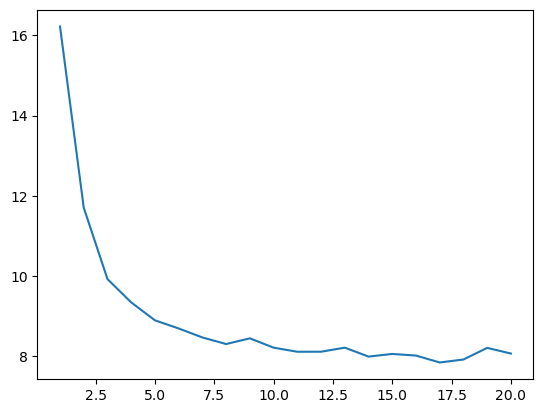

In [115]:
import matplotlib.pyplot as plt
import seaborn as sns

# Entrenamiento
epoch_count = range(1, len(history_ppl) + 1)
sns.lineplot(x=epoch_count,  y=history_ppl)
plt.show()

In [117]:
# Cargamos el mejor modelo guardado del entrenamiento para hacer inferencia
model = keras.models.load_model('my_model.keras')

In [119]:
import gradio as gr

def model_response(human_text):

    # Encodeamos
    encoded = [char2idx[ch] for ch in human_text.lower() ]
    # Si tienen distinto largo
    encoded = pad_sequences([encoded], maxlen=max_context_size, padding='pre')

    # Predicción softmax
    y_hat = np.argmax(model.predict(encoded)[0,-1,:])


    # Debemos buscar en el vocabulario el caracter
    # que corresopnde al indice (y_hat) predicho por le modelo
    out_word = ''
    out_word = idx2char[y_hat]

    # Agrego la palabra a la frase predicha
    return human_text + out_word

iface = gr.Interface(
    fn=model_response,
    inputs=["textbox"],
    outputs="text")

iface.launch(debug=True)

* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Keyboard interruption in main thread... closing server.


In [124]:
# predicción con beam search
salidas = beam_search(model,num_beams=10,num_words=20,input="la cosa anda tan fruncida")

In [125]:
salidas[0]

array([ 0, 53, 73, 63, 22, 46, 53, 73, 53, 36, 42, 53, 73, 51, 53, 36, 73,
       26,  5, 61, 36, 63, 19, 42, 53,  1, 14, 61, 37, 73, 37,  0, 73, 77,
       53, 61, 63, 31, 22, 73, 14, 61, 37, 73, 37])

In [126]:
# veamos las salidas
decode(salidas[0])

'la cosa anda tan fruncida\nque el gaucho que e'

### Conclusión 

En esta notebook se desarrolló un proyecto completo de **modelo de lenguaje a nivel de caracteres** aplicado a un corpus literario (el *Martín Fierro*).

---

### Preprocesamiento y Tokenización

- Se trabajó con texto en bruto, convirtiéndolo a minúsculas y eliminando símbolos innecesarios.
- Se definió un vocabulario de caracteres únicos (`char2idx`, `idx2char`) para codificar y decodificar texto.
- Se utilizaron técnicas como `pad_sequences` y `encode/decode` para preparar los datos como secuencias de entrada para la red.

---

### Arquitecturas de Modelo

- Se entrenaron dos variantes de redes neuronales recurrentes:
  1. **SimpleRNN**
  2. **LSTM**

- Ambos modelos fueron entrenados para predecir el **siguiente carácter** en una secuencia dada.

---

### Evaluación con Perplejidad

- Se implementó un `Callback` para calcular la **perplejidad** sobre un conjunto de validación al final de cada época.
- Esta métrica permitió monitorear la calidad del modelo durante el entrenamiento y aplicar early stopping.

---

### Generación de Texto

- Se implementaron dos estrategias para generar texto:
  - **Greedy Search**: toma siempre el carácter con mayor probabilidad.
  - **Beam Search**: mantiene múltiples trayectorias posibles para encontrar secuencias más coherentes.

- También se incorporó la **temperatura** en la versión estocástica para controlar la aleatoriedad en la generación.

---

### Conclusión final

> - Se observó que el modelo basado en **LSTM ofreció mejores resultados** en términos de **coherencia textual y menor perplejidad**. Las secuencias generadas fueron más fluidas, pero aun asi no fueron del todo exactos o esperados, probablemente falta hacer un mejor ajuste de los parametros de los modelos o bien hacer un pre tratamiento del texto diferente.
> - Finalmente, se uso el Martín Fierro, una de las obras más representativas de la literatura gauchesca argentina. Este libro no solo ofrece riqueza poética y estilística, sino que además contiene numerosas expresiones del lunfardo y habla popular rioplatense, lo cual representa un desafío interesante para el modelado de lenguaje natural.
